In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

In [2]:
df = pd.read_csv('h1.csv')

In [3]:
train_dates = pd.to_datetime(df['Timestamp'])

In [4]:
cols = list(df[df.columns[[4,6]]])
df_for_training = df[cols].astype(float)

In [5]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [6]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to predict into the future
n_past = 14     # Number of past days we want to use to predict the future

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [7]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (8620, 14, 2).
trainY shape == (8620, 1).


In [8]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 64)            17152     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 29,601
Trainable params: 29,601
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
485/485 [==============================] - 9s 18ms/step - loss: 0.3544 - val_loss: 0.5143
Epoch 2/10
485/485 [==============================] - 8s 16ms/step - loss: 0.2303 - val_loss: 0.2740
Epoch 3/10
485/485 [==============================] - 8s 17ms/step - loss: 0.1590 - val_loss: 0.2844
Epoch 4/10
485/485 [==============================] - 8s 16ms/step - loss: 0.1464 - val_loss: 0.3110
Epoch 5/10
485/485 [==============================] - 8s 16ms/step - loss: 0.1277 - val_loss: 0.2078
Epoch 6/10
485/485 [==============================] - 8s 16ms/step - loss: 0.1315 - val_loss: 0.2538
Epoch 7/10
485/485 [==============================] - 8s 16ms/step - loss: 0.1181 - val_loss: 0.2419
Epoch 8/10
485/485 [==============================] - 8s 16ms/step - loss: 0.1218 - val_loss: 0.2867
Epoch 9/10
485/485 [==============================] - 8s 16ms/step - loss: 0.1244 - val_loss: 0.2613
Epoch 10/10
485/485 [==============================] - 8s 16ms/step - loss: 0.1124 - val_lo

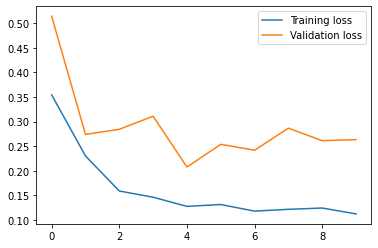

In [10]:
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.legend()

In [11]:
n_future=3000  #Redefining n_future to extend prediction dates beyond original n_future dates...
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='500N').tolist()

forecast = model.predict(trainX[-n_future:]) #forecast 

In [12]:
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [13]:
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i)

In [14]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [15]:
original = df[['Timestamp', 'cpu_usage_percentage']]
original['Timestamp']=pd.to_datetime(original['Timestamp'])

c:\users\mohammed mudassir\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


c:\users\mohammed mudassir\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\mohammed mudassir\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Timestamp', ylabel='cpu_usage_percentage'>

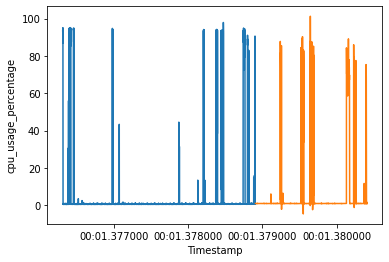

In [16]:
sns.lineplot(original['Timestamp'], original['cpu_usage_percentage'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])